# Bike sales and repairs shops in Paris using geographical data

### 1. Description of the problem and background

#### 1.1. Background

In 2015, a constatation has been made that Paris was among the european capitals were citizen use bike the least. Only 2 % of distances were made by bike which drastically contrast with cities like Copenhagen, Amsterdam or Berlin with 31%, 22% and 13% of distance made by bike.

Therefore the Paris’s city council decided the launch the program “Paris, world capital of bike” aiming at reversing the situation and make paris the top capital of the world where bike is used the most. Between 2015 and 2020 many realisations have been made including constructing new bikeways, the reduction speed limit incertain avenues and roads in Paris to insure safety cycling. In 2020 some statistic revealed that the usage of bike in paris has increased to above 15 %. 

#### 1.2. Business Problem

As investor in the sector of bike selling or reparation, such an increase of bike usage represents a great business opportunity. 

The objective of this project is to find an optimal location for a bike shops either for selling, reparation or both. The location of interest should preferentially has no many bike shops nearby and should be dense of bike users.

A second objective of the project is be to know borough or neighborhood more efficiently cover by bike facilities including bikeways and sharing shops. This can be interesting to citizen willing to make things easier by using a bike instead of a car giving the jump in the traffic and difficulties finding a parking which in fact may be expensive. 

## 2. Data acquisition and description

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

import geopy
from geopy.geocoders import Nominatim

#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
from folium.features import DivIcon

import datetime

import requests
from bs4 import BeautifulSoup
import json

### 2.1. Geographical and administrative data of Paris's Boroughs and Neighbourhoods

Get the list of borough in Paris with corresponding geographical coordinates form Paris Open data

In [2]:
def get_gson_file(url_paris):
    
    paris_dataset = requests.get(url_paris)
    paris_dataset_soup = BeautifulSoup(paris_dataset.text)
    paris_dataset      = paris_dataset_soup.find('p')
    return json.loads(paris_dataset.text)

def get_paris_boroughs(url:str, columns:list()):
    
    paris_dataset_json = get_gson_file(url)
    
    df_paris_info = pd.DataFrame(columns=columns)
    
    paris_data_map_json = {}
    for i in range(len(paris_dataset_json)) :
        borougth_info = {'oficial_name' : paris_dataset_json[i]['fields']['l_aroff'],
                         'common_name'  : paris_dataset_json[i]['fields']['l_ar'],
                         'lat_borough'  : paris_dataset_json[i]['fields']['geom_x_y'][0],
                         'long_borough' : paris_dataset_json[i]['fields']['geom_x_y'][-1],
                         'perimeter'    : paris_dataset_json[i]['fields']['perimetre'],
                         'approx_radius' : float(paris_dataset_json[i]['fields']['perimetre'])/(2*3.14)
                         }
        paris_data_map_json.update(paris_dataset_json[i]['fields'])
        df_paris_info = df_paris_info.append(borougth_info, ignore_index=True)
        
    return df_paris_info, paris_data_map_json

def merge_df(df_left, df_rigth, keys:list()):
    return pd.merge(df_left, df_rigth, how='outer', on=[keys[0], keys[1]])


In [3]:
url_paris_borough_list = "https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=json&timezone=Europe/Berlin&lang=fr"
columns=['oficial_name', 'common_name', 'lat_borough', 'long_borough', 'perimeter', 'approx_radius']

df_paris_info, paris_data_map_json = get_paris_boroughs(url_paris_borough_list, columns)
df_paris_info

,oficial_name,common_name,lat_borough,long_borough,perimeter,approx_radius
0,Popincourt,11ème Ardt,48.859059,2.380058,8282.011886,1318.791702
1,Entrepôt,10ème Ardt,48.876130,2.360728,6739.375055,1073.148894
2,Passy,16ème Ardt,48.860392,2.261971,17416.109657,2773.265869
3,Vaugirard,15ème Ardt,48.840085,2.292826,13678.798315,2178.152598
4,Batignolles-Monceau,17ème Ardt,48.887327,2.306777,10775.579516,1715.856611
5,Ménilmontant,20ème Ardt,48.863461,2.401188,10704.940486,1704.608358
6,Panthéon,5ème Ardt,48.844443,2.350715,6239.195396,993.502452
7,Élysée,8ème Ardt,48.872721,2.312554,7880.533268,1254.861985
8,Luxembourg,6ème Ardt,48.849130,2.332898,6483.686786,1032.434202
9,Gobelins,13ème Ardt,48.828388,2.362272,11546.546526,1838.622058


In [4]:
# Generate map centred around the Louvre borough center
centerborough_index = df_paris_info[df_paris_info['common_name']=='1er Ardt'].index
borough_map = folium.Map(location=[df_paris_info.lat_borough[centerborough_index[0]],
                                  df_paris_info.long_borough[centerborough_index[0]]],
                                  zoom_start=12)

# Add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker([df_paris_info.lat_borough[centerborough_index[0]],
                              df_paris_info.long_borough[centerborough_index[0]]],
                radius=15,
                color='red',
                popup='LOUVRE',
                fill = True,
                fill_color = 'red',
                fill_opacity = 0.75
                ).add_to(borough_map)

#colors_map = ['BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']
paris_data_map_dict = json.loads(requests.get('https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr').text)

borough_map.choropleth(
    geo_data = paris_data_map_dict, #paris_data_map_json, #paris_data_map_dict, 
    data = df_paris_info,          
    name = 'choropleth',
    columns = ['oficial_name', 'perimeter'], 
    fill_color = 'GnBu', 
    key_on = 'feature.properties.l_aroff',
    fill_opacity=0.7, 
    line_opacity=1.9,
    #fill_color='YlGn',
    legend_name = 'Perimeter'
)

for lat, lng, label in zip(df_paris_info.lat_borough, df_paris_info.long_borough, df_paris_info.oficial_name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.85
        ).add_to(borough_map)

for lat, lng, label in zip([48.8399252, 48.8310882], [2.3904693, 2.437153], df_paris_info.oficial_name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        fill=True,
        color='magenta',
        fill_color='magenta',
        fill_opacity=0.85
        ).add_to(borough_map)

# display map
borough_map

## 2.2. Data of Paris bikeway network

In [11]:
# Get the bike way network and distance in km in paris
url_bike_way = 'https://parisdata.opendatasoft.com/explore/dataset/reseau-cyclable/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B'
df_bike_way = pd.read_csv(url_bike_way, delimiter = ';')

# Add bourough column for merging purposes
df_bike_way['common_name'] = df_bike_way['Arrondissement'].apply( lambda x : str(x).split('.')[0] + 'ème Ardt' \
                             if (x != 'NaN' and str(x).split('.')[0] != '1') else \
                             (str(x).split('.')[0] + 'er Ardt' if str(x).split('.')[0] == '1' else 'NaN') )

# Group the data by borough
df_bikeway_borough = df_bike_way.groupby('Arrondissement').sum().reset_index()

df_bikeway_borough = pd.merge(df_bike_way[['common_name', 'Arrondissement']], 
                              df_bikeway_borough[['Longueur du tronçon en km', 'Arrondissement']],
                              how='inner', on=['Arrondissement', 'Arrondissement'])

# drop non necessairely columns 
df_bikeway_borough.drop_duplicates(inplace=True)
df_bikeway_borough.drop(columns=['Arrondissement'], inplace=True)

df_bikeway_borough

,common_name,Longueur du tronçon en km
0,13ème Ardt,86.732602
1165,12ème Ardt,112.089896
2218,8ème Ardt,37.354241
2783,4ème Ardt,33.884346
3343,14ème Ardt,55.352697
4088,15ème Ardt,76.875881
4939,16ème Ardt,72.048934
5559,7ème Ardt,35.140342
5875,6ème Ardt,23.161381
6183,11ème Ardt,56.325679


### 2.2. Paris bike shops : Foursquare data

In [5]:
# Get foursquare credentials
f = open("Foursquare_credentials.txt", "r")
credential = []
for x in f:
    credential.append(x.split('=')[-1])
CLIENT_ID     = credential[0][0:-1]
CLIENT_SECRET = credential[1][0:-1]

VERSION       = '20200101'
LIMIT         = 99500

search_query_list  = ['Bike', 'Byke' 'Vélo', 'bicyclette', 'velos', 'Cyclable', 'Bicycle', 'CYCLES',
                      'cyclistes', 'Bicloune', 'Buzibi', 'Bicycland', "Bicycl'Art", 'Velotority',
                      'Cycloparis15', 'MOBICITY', 'Cyclo-store', 'Velobecane', 'vintelo', 'Cyclable']

df_bikeshops_paris = pd.DataFrame(columns = ['shop name', 'shop lat_long coord', 'borough', 'categories'])

for i in range(len(df_paris_info)):
    
    for search_query_value in search_query_list :
        
        search_query = search_query_value
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'\
                    .format(CLIENT_ID, CLIENT_SECRET, df_paris_info.lat_borough[i],
                            df_paris_info.long_borough[i], VERSION, search_query,
                            df_paris_info.approx_radius[i], LIMIT)
        
        bikes_results = requests.get(url).json()
        reponse = bikes_results['response']
    
        for j in range(len(reponse['venues'])):
            venue = reponse['venues'][j]
            try :
                categories =  venue['categories'][0]['shortName']
            except :
                categories = None

            reformate_venue = {'shop name'    : venue['name'],
                               'shop lat_long coord' : [venue['location']['lat'], venue['location']['lng']],
                               'borough' : df_paris_info.common_name[i].split()[0] + ' ' + df_paris_info.oficial_name[i],
                               'categories' : categories
                              }
            df_bikeshops_paris = df_bikeshops_paris.append(reformate_venue, ignore_index=True)

# Add borough_join column for merging purposes        
df_bikeshops_paris['common_name'] = df_bikeshops_paris['borough'] \
                                     .apply(lambda x : x.split(' ')[0] + ' Ardt' if x != 'NaN' else 'NaN')

In [6]:
df_bikeshops_paris.head()

,shop name,shop lat_long coord,borough,categories,common_name
0,By my bike,"[48.856997, 2.374731]",11ème Popincourt,Motorcycle Shop,11ème Ardt
1,Bike 2 Wheel,"[48.855317, 2.369427]",11ème Popincourt,Motorcycle Shop,11ème Ardt
2,Systeme Bike,"[48.86441169386982, 2.3681970557553993]",11ème Popincourt,Bike Shop,11ème Ardt
3,Système Bike,"[48.8655599, 2.3657182]",11ème Popincourt,Auto Garage,11ème Ardt
4,Paris Bike Tour,"[48.86180577696176, 2.363275171084977]",11ème Popincourt,Bike,11ème Ardt


In [7]:
# Select the top 50 common vennues categories
def top_venues_categories(nbr_to:int, df:pd.DataFrame):
    top_categories = df.groupby('categories').count().sort_values('shop name', ascending=False)\
                                               .head(nbr_to).index.tolist()
    df_top_bikeshops = pd.DataFrame()
    for category in top_categories:
        df_top_category = df[df['categories']== category]
        df_top_bikeshops = pd.concat([df_top_bikeshops, df_top_category])
    
    for value in df_top_bikeshops['borough'].unique():
        df_top_bikeshops.replace(value, value.split(' ')[-1], inplace=True)
    
    df_top_bikeshops.reset_index(drop= True, inplace=True)
    
    return df_top_bikeshops
    
df_top_bikeshops = top_venues_categories(60, df_bikeshops_paris)
df_top_bikeshops.head()

,shop name,shop lat_long coord,borough,categories,common_name
0,Systeme Bike,"[48.86441169386982, 2.3681970557553993]",Popincourt,Bike Shop,11ème Ardt
1,Mon Beau Vélo !,"[48.85888394, 2.38307916]",Popincourt,Bike Shop,11ème Ardt
2,Rapid Vélos,"[48.857191495390886, 2.379605382868096]",Popincourt,Bike Shop,11ème Ardt
3,Velo vintage,"[48.859095, 2.385368]",Popincourt,Bike Shop,11ème Ardt
4,Les petits vélos de Maurice,"[48.85591217616947, 2.383458538466083]",Popincourt,Bike Shop,11ème Ardt


### 2.3. Paris bike counting data

In [14]:
# Get the dataset of daily counting of bike various locations in Paris 
url_csv = 'https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/download/?format=csv&timezone=Europe/Paris&lang=fr&use_labels_for_header=true&csv_separator=%3B'
df_bike_count = pd.read_csv('../comptage-velo-donnees-compteurs.csv', delimiter = ';')

# drop duplicate to gain time
df_bike_count_unique = df_bike_count.drop_duplicates('Identifiant du site de comptage').reset_index(drop=True)

locator = Nominatim(user_agent='myGeocoderTest')

def get_borough(coordinate):
    coordinate = str(coordinate)
    location = locator.reverse(coordinate)
    
    location_dict = location.raw
    try :
        # 'city_district' in location_dict['address'].keys()
        address = location_dict['address']['postcode'] + ' ' + location_dict['address']['city_district']
    except KeyError : 
        address = location_dict['address']['postcode'] + ' ' + location_dict['address']['suburb']
    
    except :
        name = location_dict['display_name']
        address = location_dict['address']['postcode'] + ' ' + name.split(',')[1]
    
    rang = int(address.split(' ')[0][-2:])
    if rang != "1" :
        return str(rang)+'ème Ardt'
    elif rang == '1':
        return str(rang)+'er Ardt'

df_bike_count_unique['common_name'] = df_bike_count_unique['Coordonnées géographiques']\
                                       .apply(lambda x : get_borough(x))
df_bike_count_unique.head()

,Identifiant du compteur,Nom du compteur,Identifiant du site de comptage,Nom du site de comptage,Comptage horaire,Date et heure de comptage,Date d'installation du site de comptage,Lien vers photo du site de comptage,Coordonnées géographiques,common_name
0,100003096-SC,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau SO-NE,10,2019-04-25T07:00:00+02:00,2012-02-22,https://www.eco-visio.net/Photos/100003096/157...,"48.834695,2.332968",14ème Ardt
1,100003097-SC,105 rue La Fayette E-O,100003097,105 rue La Fayette E-O,14,2019-04-25T00:00:00+02:00,2012-02-13,https://www.eco-visio.net/Photos/100003097/157...,"48.877667,2.350556",10ème Ardt
2,100003098-SC,106 avenue Denfert Rochereau NE-SO,100003098,106 avenue Denfert Rochereau NE-SO,29,2019-04-25T00:00:00+02:00,2012-02-22,https://www.eco-visio.net/Photos/100003098/133...,"48.835143,2.333031",14ème Ardt
3,100003099-SC,100 rue La Fayette O-E,100003099,100 rue La Fayette O-E,24,2019-04-25T08:00:00+02:00,2012-02-22,https://www.eco-visio.net/Photos/100003099/133...,"48.87746,2.35008",10ème Ardt
4,100006300-SC,135 avenue Daumesnil SE-NO,100006300,135 avenue Daumesnil SE-NO,13,2019-04-25T06:00:00+02:00,2013-01-19,https://www.eco-visio.net/Photos/100006300/157...,"48.843435,2.383378",12ème Ardt


In [13]:
# join df_bike_count_unique to the df_bike_count_unique
df_bike_count_join_borough = pd.merge(df_bike_count,
                df_bike_count_unique[['Identifiant du site de comptage', 'common_name']], how ='outer',
                on=['Identifiant du site de comptage', 'Identifiant du site de comptage'])

df_bike_count_join_borough['Date et heure de comptage'] = pd.to_datetime(
                                              df_bike_count['Date et heure de comptage'])

df_bike_count_join_borough['Datetime_count'] = df_bike_count_join_borough['Date et heure de comptage']\
                                               .apply(lambda x: x.replace(tzinfo=None))

df_bike_count_jan20_feb20 = df_bike_count_join_borough[
    (df_bike_count_join_borough['Datetime_count'] < datetime.datetime(2020, 3, 1, 0, 0)) & \
    (df_bike_count_join_borough['Datetime_count'] > datetime.datetime(2020, 1, 1, 0, 0))]

df_bike_count_jan20_feb20.reset_index(drop=True, inplace=True)
df_bike_count_jan20_feb20['week_day'] = df_bike_count_jan20_feb20['Date et heure de comptage']\
                                                            .apply(lambda x: x.weekday())
df_bike_count_jan20_feb20.drop(columns=["Date d'installation du site de comptage", 
           "Lien vers photo du site de comptage", "Identifiant du compteur", "Nom du compteur"], inplace=True)

df_bike_count_jan20_feb20.head()

/home/donald/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/donald/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Identifiant du site de comptage,Nom du site de comptage,Comptage horaire,Date et heure de comptage,Coordonnées géographiques,common_name,Datetime_count,week_day
0,100003096,97 avenue Denfert Rochereau SO-NE,9,2020-01-01 02:00:00+01:00,"48.834695,2.332968",14ème Ardt,2020-01-01 02:00:00,2
1,100003096,97 avenue Denfert Rochereau SO-NE,11,2020-01-01 11:00:00+01:00,"48.834695,2.332968",14ème Ardt,2020-01-01 11:00:00,2
2,100003096,97 avenue Denfert Rochereau SO-NE,17,2020-01-01 14:00:00+01:00,"48.834695,2.332968",14ème Ardt,2020-01-01 14:00:00,2
3,100003096,97 avenue Denfert Rochereau SO-NE,18,2020-01-01 17:00:00+01:00,"48.834695,2.332968",14ème Ardt,2020-01-01 17:00:00,2
4,100003096,97 avenue Denfert Rochereau SO-NE,22,2020-01-01 18:00:00+01:00,"48.834695,2.332968",14ème Ardt,2020-01-01 18:00:00,2


In [15]:
df_bike_daily_mean = df_bike_count_join_borough.groupby('common_name').mean().reset_index()
df_bike_daily_mean.head()

,common_name,Identifiant du site de comptage,Comptage horaire
0,10ème Ardt,1.000253e+08,99.335425
1,11ème Ardt,1.000463e+08,94.030620
2,12ème Ardt,1.000364e+08,30.995572
3,13ème Ardt,1.000469e+08,38.065501
4,14ème Ardt,1.000291e+08,33.021001


In [108]:
df_info_bikeway = merge_df(df_paris_info, df_bikeway_borough, ['common_name', 'common_name'])

df_info_bikeway_shopes = merge_df(df_info_bikeway, df_top_bikeshops, ['common_name', 'common_name'])

df_final_dataset = merge_df(df_info_bikeway_shopes, df_bike_daily_mean[['common_name', 'Comptage horaire']],
                                  ['common_name', 'common_name'])

df_final_dataselection = df_final_dataset[['oficial_name', 'common_name', 'Longueur du tronçon en km',
                                                                    'categories', 'Comptage horaire']]

df_final_dataselection.rename(columns={'Longueur du tronçon en km' : 'bike_way_lenght',
                               'Comptage horaire' : 'daily_bike_counting'}, inplace=True)
df_final_dataselection.fillna(df_final_dataselection.mean(), inplace=True)

df_final_dataselection.head()

/home/donald/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/donald/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,oficial_name,common_name,bike_way_lenght,categories,daily_bike_counting
0,Popincourt,11ème Ardt,56.325679,Bike Shop,94.03062
1,Popincourt,11ème Ardt,56.325679,Bike Shop,94.03062
2,Popincourt,11ème Ardt,56.325679,Bike Shop,94.03062
3,Popincourt,11ème Ardt,56.325679,Bike Shop,94.03062
4,Popincourt,11ème Ardt,56.325679,Bike Shop,94.03062


## 3. SEGMENTATION 

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [109]:
df_bikeshops_onehot = pd.get_dummies(df_final_dataselection[['categories']], prefix="", prefix_sep="")

df_bikeshops_onehot.head()

,Adult Boutique,Antiques,Apparel,Art Gallery,Art Museum,Arts & Crafts,Auto Dealer,Automotive,Bakery,Bank,...,Shop,Shops,Smoke Shop,Sporting Goods,Street Art,Supermarket,Tech Startup,Thrift / Vintage,Toys & Games,Travel Agency
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
scaler = StandardScaler()

df_bikeshops_onehot['bike_way_lenght_scaler'] = scaler.fit_transform(df_final_dataselection[['bike_way_lenght']])
df_bikeshops_onehot['daily_bike_counting_scaler'] = scaler.fit_transform(df_final_dataselection[['daily_bike_counting']])

df_bikeshops_onehot.head()

,Adult Boutique,Antiques,Apparel,Art Gallery,Art Museum,Arts & Crafts,Auto Dealer,Automotive,Bakery,Bank,...,Smoke Shop,Sporting Goods,Street Art,Supermarket,Tech Startup,Thrift / Vintage,Toys & Games,Travel Agency,bike_way_lenght_scaler,daily_bike_counting_scaler
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.123831,1.334363
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.123831,1.334363
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.123831,1.334363
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.123831,1.334363
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.123831,1.334363


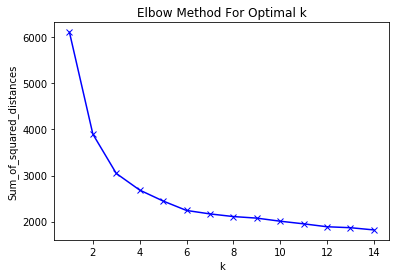

In [111]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_bikeshops_onehot)
    Sum_of_squared_distances.append(km.inertia_)
    

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [112]:
kclusters = 6

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_bikeshops_onehot)

In [113]:
df_bikeshops_onehot.insert(0, 'Cluster Labels', kmeans.labels_)
df_final_dataselection.insert(0, 'Cluster Labels', kmeans.labels_)

df_bikeshops_onehot.head()
#df_final_dataselection.head()

,Cluster Labels,Adult Boutique,Antiques,Apparel,Art Gallery,Art Museum,Arts & Crafts,Auto Dealer,Automotive,Bakery,...,Smoke Shop,Sporting Goods,Street Art,Supermarket,Tech Startup,Thrift / Vintage,Toys & Games,Travel Agency,bike_way_lenght_scaler,daily_bike_counting_scaler
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.123831,1.334363
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.123831,1.334363
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.123831,1.334363
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.123831,1.334363
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.123831,1.334363


## 4. Result analysis

#### 4.1. Segmentation map

In [155]:
# create a DataFrame for segmentation map representation
df_cluster_map = df_final_dataselection.drop_duplicates('oficial_name')\
                      .sort_values('Cluster Labels').set_index('Cluster Labels', 'oficial_name').reset_index()
df_cluster_map = merge_df(df_cluster_map, df_paris_info[['common_name', 'lat_borough', 'long_borough']],
                          ['common_name', 'common_name'])
df_cluster_map

,Cluster Labels,oficial_name,common_name,bike_way_lenght,categories,daily_bike_counting,lat_borough,long_borough
0,0,Opéra,9ème Ardt,27.981652,Bike Shop,53.075152,48.877164,2.337458
1,0,Palais-Bourbon,7ème Ardt,35.140342,Bike Shop,45.851804,48.856174,2.312188
2,0,Temple,3ème Ardt,16.803117,Bike Shop,65.269929,48.862872,2.360001
3,0,Élysée,8ème Ardt,37.354241,Bike Shop,53.956282,48.872721,2.312554
4,0,Luxembourg,6ème Ardt,23.161381,Bike Shop,33.295519,48.849130,2.332898
5,0,Hôtel-de-Ville,4ème Ardt,33.884346,Bike Shop,54.986937,48.854341,2.357630
6,0,Louvre,1er Ardt,39.120423,Bike Shop,53.075152,48.862563,2.336443
7,1,Gobelins,13ème Ardt,86.732602,Bike Shop,38.065501,48.828388,2.362272
8,1,Passy,16ème Ardt,72.048934,Bike Shop,38.792527,48.860392,2.261971
9,1,Vaugirard,15ème Ardt,76.875881,Bike Shop,33.635366,48.840085,2.292826


## Create the map

In [154]:
# Generate map centred around the Louvre borough center
centerborough_index = df_paris_info[df_paris_info['common_name']=='1er Ardt'].index
borough_map = folium.Map(location=[df_paris_info.lat_borough[centerborough_index[0]],
                                  df_paris_info.long_borough[centerborough_index[0]]],
                                  zoom_start=12)

#colors_map = ['BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']
colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'white']
paris_data_map_dict = json.loads(requests.get('https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr').text)

borough_map.choropleth(
    geo_data = paris_data_map_dict, #paris_data_map_json, #paris_data_map_dict, 
    data = df_cluster_map,          
    name = 'choropleth', 
    columns = ['oficial_name', 'Cluster Labels'],
    #threshold_scale=[0, 100, 500, 1000, 1500, 2000],
    fill_color = 'RdPu', 
    key_on = 'feature.properties.l_aroff',
    fill_opacity=0.8, 
    line_opacity=1.0,
    line_color = 'blue',
    line_weight = 1.20,
    #fill_color='YlGn',
    reset=True,
    legend_name = 'Cluster'
)

for lat, lng, label, cluster in zip(df_cluster_map.lat_borough, df_cluster_map.long_borough, 
                                    df_cluster_map.oficial_name, df_cluster_map['Cluster Labels']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=str(label),
        fill=True,
        color=colors[cluster],
        fill_color=colors[cluster],
        fill_opacity=0.95
        ).add_to(borough_map)
    
    text = str(cluster) 
    Text = folium.Marker(location=[lat, lng], popup= str(cluster),
                        icon=DivIcon(icon_size=(50,12),
                                     icon_anchor=(0,0),
                                     html='<div style="font-size: 16pt">%s</div>' % text)
                            )
    borough_map.add_child(Text)
    
# display map
borough_map

## bike counting and bikeway lenght per cluster

In [192]:
df_final_dataselection.groupby('Cluster Labels').mean()

,bike_way_lenght,daily_bike_counting
Cluster Labels,,
0,30.677042,51.794731
1,78.259006,40.560690
2,44.868703,93.452949
3,24.721218,141.852432
4,112.089896,30.995572
5,55.876220,18.384513


## Top 5 bike shops per borough

In [194]:
def result_analysis(df:pd.DataFrame, column:str):
    result = pd.DataFrame()
    for i in df[column].unique():
        df_cluster = df[df[column]==i].groupby('categories').count()\
                    .sort_values('oficial_name', ascending=False)[['Cluster Labels']].head(5)
        df_cluster.rename(columns={'Cluster Labels':'Cluster_{}'.format(i)}, inplace=True)
        
        result = pd.concat([result, df_cluster], axis=1)
    return result

df_cluster = result_analysis(df_final_dataselection, 'Cluster Labels')

result_stact = pd.DataFrame(df_cluster.T.sort_index().stack())

result_stact.rename(columns={0:'Count'})

Count
Cluster_0 Bike Shop       42.0
          Art Gallery     79.0
          Bus Stop        58.0
          Bike            39.0
          Apparel         52.0
Cluster_1 Bike Shop       78.0
          Art Gallery     32.0
          Residential     19.0
          Bike            45.0
          Bakery          18.0
Cluster_2 Bike Shop       51.0
          Art Gallery     24.0
          Residential     16.0
          Bus Stop        13.0
          Bike            13.0
Cluster_3 Bike Shop        6.0
          Art Gallery      9.0
          Bike             5.0
          Apparel          8.0
          Office           5.0
Cluster_4 Bike Shop       34.0
          Art Gallery      9.0
          Bike             8.0
          Road             7.0
          Travel Agency    6.0
Cluster_5 Bike Shop       32.0
          Art Gallery     22.0
          Residential     18.0
          Bus Stop        17.0
          Bike            28.0

## Bar plot of the result

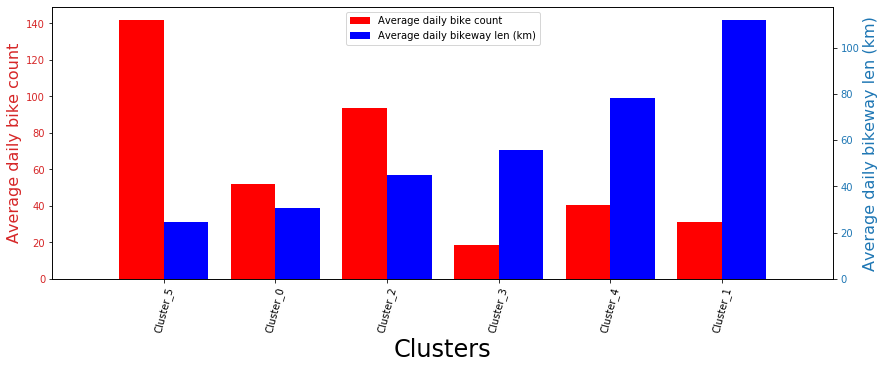

In [193]:
fig = plt.figure(figsize=(14, 5)) # Create matplotlib figure

ax = fig.add_subplot(111)         # Create matplotlib axes

ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

df_result_plot = df_final_dataselection.groupby('Cluster Labels').mean().reset_index()\
                                                                 .sort_values('bike_way_lenght')
df_result_plot['Cluster Labels'] = ['Cluster_5', 'Cluster_0', 'Cluster_2', 
                                                 'Cluster_3', 'Cluster_4', 'Cluster_1']
df_result_plot.plot(kind='bar', color='red', x='Cluster Labels', y='daily_bike_counting',
                                             ax=ax, width=0.4, position=1, rot=75, legend=False)

df_result_plot.plot(kind='bar', color='blue', x='Cluster Labels', y='bike_way_lenght',
                     ax=ax2, width=0.4, position=0, legend=False)

ax.set_xlabel('Clusters', size=24)
ax.tick_params(axis='x') 
ax.set_xlim([-10, 6])
h1, l1 = ax.get_legend_handles_labels()
l1 = ['Average daily bike count']

#ax.legend(h1, l1, loc=1)
h2, l2 = ax2.get_legend_handles_labels()
l2 = ['Average daily bikeway len (km)'] # rename the legend
ax2.legend(h1+h2, l1+l2, loc=9)

color = 'tab:red'
ax.set_ylabel('Average daily bike count', color=color, size=16)
ax.tick_params(axis='y', labelcolor=color) #, size=16

color = 'tab:blue'
ax2.set_ylabel('Average daily bikeway len (km)', color=color, size=16)
ax2.tick_params(axis='y', labelcolor=color) #, size=16
ax2.set_xlim([-1, 6])
plt.savefig('Discussion_bar.png')

plt.show()

In [58]:
df_bikeshops_onehot['oficial_name']= df_final_dataselection['oficial_name']
df_bikeshops_onehot['common_name'] = df_final_dataselection['common_name']
df_bikeshops_onehot.head()

,Cluster Labels,Adult Boutique,Antiques,Apparel,Art Gallery,Art Museum,Arts & Crafts,Auto Dealer,Automotive,Bakery,...,Sporting Goods,Street Art,Supermarket,Tech Startup,Thrift / Vintage,Toys & Games,Travel Agency,bike_way_lenght_scaler,oficial_name,common_name
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.123831,Popincourt,11ème Ardt
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.123831,Popincourt,11ème Ardt
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.123831,Popincourt,11ème Ardt
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.123831,Popincourt,11ème Ardt
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.123831,Popincourt,11ème Ardt


In [59]:
df_cluster_0 = df_bikeshops_onehot[df_bikeshops_onehot['Cluster Labels']==0]
df_cluster_0.groupby('common_name').count().reset_index().drop_duplicates(subset ="common_name")

,common_name,Cluster Labels,Adult Boutique,Antiques,Apparel,Art Gallery,Art Museum,Arts & Crafts,Auto Dealer,Automotive,...,Smoke Shop,Sporting Goods,Street Art,Supermarket,Tech Startup,Thrift / Vintage,Toys & Games,Travel Agency,bike_way_lenght_scaler,oficial_name
0,10ème Ardt,76,76,76,76,76,76,76,76,76,...,76,76,76,76,76,76,76,76,76,76
1,1er Ardt,88,88,88,88,88,88,88,88,88,...,88,88,88,88,88,88,88,88,88,88
2,2ème Ardt,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
3,3ème Ardt,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
4,4ème Ardt,94,94,94,94,94,94,94,94,94,...,94,94,94,94,94,94,94,94,94,94
5,5ème Ardt,64,64,64,64,64,64,64,64,64,...,64,64,64,64,64,64,64,64,64,64
6,6ème Ardt,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,80,80
7,7ème Ardt,78,78,78,78,78,78,78,78,78,...,78,78,78,78,78,78,78,78,78,78
8,8ème Ardt,94,94,94,94,94,94,94,94,94,...,94,94,94,94,94,94,94,94,94,94
9,9ème Ardt,106,106,106,106,106,106,106,106,106,...,106,106,106,106,106,106,106,106,106,106
